# Solar Production and Economics Analysis
This notebook demonstrates the use of the solar production and economics functions for a private solar panel project.

```{toc}
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from solar_production import (
    read_power_price,
    read_consumption,
    read_production,
    compare_actual_consumption_to_average,
    apparent_adoption_factor,
    total_investment_cost
)

In [2]:

from typing import Literal


def calculate_solar_economics(
    production_hourly: pd.Series,  # kWh/hour for one year (DatetimeIndex)
    spot_price_hourly: pd.Series,  # NOK/kWh/hour for one year (DatetimeIndex)
    consumption_hourly: pd.Series,  # kWh/hour for one year (DatetimeIndex)
    investment_cost: float,
    lifetime_years: int = 30, # lifetime of the cells
    degradation_per_year: float = 0.005,
    grid_tariff: float = 0.49 * 0.8,  # NOK/kWh - 25% vat
    system_losses: float = 0.14,
    norges_pris: Literal[False] | float = False,
    inflation=0.03,
):
    """
    Calculates the financial performance of a solar PV system
    based on hourly time series for a representative year.
    Series must have a DatetimeIndex covering one year (8760 hours).
    """

    # Input checks
    assert isinstance(production_hourly.index, pd.DatetimeIndex), "Production must have DatetimeIndex"
    assert isinstance(spot_price_hourly.index, pd.DatetimeIndex), "Spot price must have DatetimeIndex"
    assert isinstance(consumption_hourly.index, pd.DatetimeIndex), "Consumption must have DatetimeIndex"
    assert len(production_hourly) == len(spot_price_hourly) == len(consumption_hourly), (
        "All time series must be the same length"
    )

    # Ensure sorted index
    production_hourly = production_hourly.sort_index()
    spot_price_hourly = spot_price_hourly.sort_index()
    consumption_hourly = consumption_hourly.sort_index()

    results = []
    cumulative_cashflow = 0
    payback_years = None

    # Apply system losses to the base year
    base_production = production_hourly * (1 - system_losses)

    for year in range(1, lifetime_years + 1):
        # Apply degradation
        degradation_factor = (1 - degradation_per_year) ** (year - 1)
        yearly_production = base_production * degradation_factor

        # Self-consumption = min(production, consumption) each hour
        self_consumption_series = yearly_production.combine(consumption_hourly, min)
        self_consumption_kWh = self_consumption_series.sum()

        # Surplus to grid
        surplus_series = (yearly_production - consumption_hourly).clip(lower=0)
        surplus_kWh = surplus_series.sum()

        # Value of self-consumption = saved (spot price + grid tariff)
        # If you have 'norges-pris' the power-price is capped at e.g. 0.4 NOK/kWh
        if norges_pris:
            consumption_power_price = norges_pris
        else:
            consumption_power_price = spot_price_hourly
        consumption_power_price = (consumption_power_price + grid_tariff) * 1.25  # (25% vat)
        saved_self_consumption_NOK = (self_consumption_series * consumption_power_price).sum()

        # Value of surplus sales = spot price
        sales_NOK = (surplus_series * spot_price_hourly).sum()

        # Total revenue for the year
        yearly_income = saved_self_consumption_NOK + sales_NOK

        # Add to cumulative totals
        inflation_adjustment = (1 + inflation) ** (year - 1)
        cumulative_cashflow += yearly_income * inflation_adjustment

        # Check simple payback (not accounting for interest)
        if payback_years is None and cumulative_cashflow >= investment_cost:
            payback_years = year

        results.append(
            {
                "Year": year,
                "Production (kWh)": yearly_production.sum(),
                "Self-consumption (kWh)": self_consumption_kWh,
                "Exported (kWh)": surplus_kWh,
                "Income (NOK)": yearly_income,
                "Cumulative (NOK)": cumulative_cashflow,
            }
        )

    results_df = pd.DataFrame(results)

    return {
        "results": results_df,
        "total_profit": cumulative_cashflow - investment_cost,
        "payback_period_years": payback_years,
    }

## Compare actual consumption to average
This step calculates the adoption factor for actual (based on a specific meter) vs. average household consumption in NO1 (used here).

array([0.93673812, 0.97658961, 0.96246867, 0.94546721, 1.09206854,
       1.2191586 , 1.23967164, 1.16788206, 1.03472942, 0.83919472,
       0.98250599, 0.89514701])

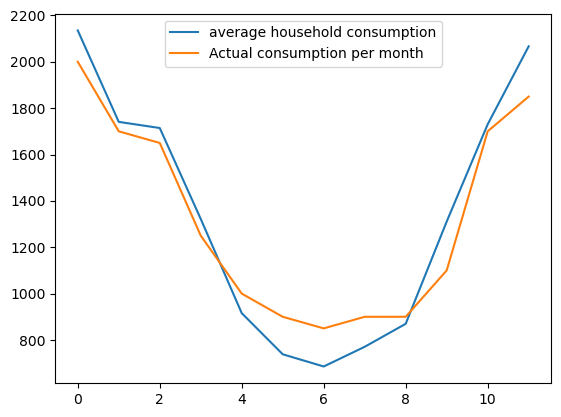

In [3]:
consume_adoption_factor_org = compare_actual_consumption_to_average()
consume_adoption_factor_org

## Main analysis loop
Loop over different scenarios and years, and collect results.

In [ ]:
results = []
loan_years = 20

print("Calculating the economics\n")

total_cost_max, total_interrest = total_investment_cost(
    investment_amount=265_000,
    annual_interest_rate=0.05,
    loan_years=loan_years,
)

for total_cost in [total_cost_max, 265_000 + 35_000]:
    for norges_pris in [False, 0.4]:
        print(f'\nNorges-pris: {norges_pris}')
        for year in ['2023', '2024']:
            print(f'Calculating for year: {year}')

            # for consume_adoption_factor in [True, False]:
            #     if consume_adoption_factor:
            #         adoption_factor = apparent_adoption_factor(adoption_factor=consume_adoption_factor_org, year=year)
            #         adoption_factor = adoption_factor.to_numpy().squeeze()
            #     else:
            #         adoption_factor = 1
            adoption_factor = 1

            production = read_production(year)
            spot_price = read_power_price().loc[year]
            consumption = read_consumption(year, total=16_000) * adoption_factor

            # NOTE: Adjust to the correct investment cost

            result = calculate_solar_economics(
                production_hourly=production,
                spot_price_hourly=spot_price,
                consumption_hourly=consumption,
                investment_cost=total_cost,
                lifetime_years=35,
                degradation_per_year=0.005,  # 0.5%
                grid_tariff=0.5,  # NOK/kWh
                system_losses=0.12,
                norges_pris=norges_pris,
            )

            results.append([
                # consume_adoption_factor,
                round(total_cost),
                norges_pris,
                year,
                round(result['total_profit']),
                result['payback_period_years'],
            ])


Calculating the economics


Norges-pris: False
Calculating for year: 2023
Calculating for year: 2024
Calculating for year: 2024

Norges-pris: 0.4
Calculating for year: 2023

Norges-pris: 0.4
Calculating for year: 2023
Calculating for year: 2024
Calculating for year: 2024

Norges-pris: False
Calculating for year: 2023

Norges-pris: False
Calculating for year: 2023
Calculating for year: 2024
Calculating for year: 2024

Norges-pris: 0.4
Calculating for year: 2023

Norges-pris: 0.4
Calculating for year: 2023
Calculating for year: 2024
Calculating for year: 2024


## Summary of the main results

In [18]:
# Convert results to a DataFrame and display
results_df = pd.DataFrame(
    results,
    columns=[
        # 'consume_adoption_factor',
        "total_cost",
        'norges_pris',
        'year',
        'total_profit',
        'payback_period_years',
    ],
)
results_df

# Display with thousands separator (space for Norwegian style, comma for US style)
results_df.style.format({
    "total_cost": "{:,.0f}".format, # comma as thousands separator, no decimals
    "total_profit": "{:,.0f}".format,
    "norges_pris": "{:.2f}".format     
})

,total_cost,norges_pris,year,total_profit,payback_period_years
0,"419,732",0.00,2023,"700,455",17
1,"419,732",0.00,2024,"328,070",24
2,"419,732",0.40,2023,"486,438",20
3,"419,732",0.40,2024,"254,465",26
4,"300,000",0.00,2023,"820,187",13
5,"300,000",0.00,2024,"447,802",18
6,"300,000",0.40,2023,"606,170",16
7,"300,000",0.40,2024,"374,197",20


## Plotting
You can plot the results for further analysis.

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), dpi=200)
production.plot(ax=ax[0], lw=0.1, label="Production")
consumption.plot(ax=ax[0], label="Consumption")
spot_price.plot(ax=ax[1], label="Spot Price")
ax[0].legend()
ax[1].legend()
plt.show()